## Converting task.json to test.csv

##### Note: Don't run this block if the test.csv already exists. Move to next blocks for evaluation

In [1]:
import json
import pandas as pd

In [2]:
# Load JSON (replace with loading from file if needed)
with open("task.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [3]:
# Extract examples
test_dict = {"text" : [], "sarcastic" : []}
for ex in data["examples"]:
    input_text = ex["input"]
    target = ex["target_scores"]
    
    # Extract sentence (a) and (b)
    try:
        s_a = input_text.split("(a)")[1].split("(b)")[0].strip()
        s_b = input_text.split("(b)")[1].strip()
    except IndexError:
        continue  # skip malformed example
    
    label_a = target["(a)"]
    label_b = target["(b)"]

    test_dict["text"].extend([s_a, s_b])
    test_dict["sarcastic"].extend([label_a, label_b])

bb_test_df = pd.DataFrame(test_dict).sample(frac=1, random_state = 10).reset_index(drop=True)
bb_test_df.head()

,text,sarcastic
0,Better not buy any exorbitant technology ever ...,0
1,"So if there are more dollars, more people can ...",0
2,With new designs coming ten times slower than ...,1
3,You mean you're only into bullies with narciss...,0
4,Never had as much fun in my life as when the c...,1


In [4]:
bb_test_df['sarcastic'].value_counts()

sarcastic
0    181
1    181
Name: count, dtype: int64

In [5]:
bb_test_df.to_csv(r"BIG-Bench-SNARKS\test.csv", index=False)

## Evaluation

### 0) Loading Data

In [6]:
bb_test_df = pd.read_csv(r"BIG-Bench-SNARKS\test.csv")
bb_test_df.head()

,text,sarcastic
0,Better not buy any exorbitant technology ever ...,0
1,"So if there are more dollars, more people can ...",0
2,With new designs coming ten times slower than ...,1
3,You mean you're only into bullies with narciss...,0
4,Never had as much fun in my life as when the c...,1


### 1) Bi-RNN with Flat Attention Networks (FAN)

In [7]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def load_data(folder_path):
    train_df = pd.read_csv(os.path.join(folder_path, 'train.csv'))
    val_df = pd.read_csv(os.path.join(folder_path, 'val.csv'))
    test_df = pd.read_csv(os.path.join(folder_path, 'test.csv'))
    return train_df, val_df, test_df

def build_vocab(dataframes, vocab_size=20000):
    word_freq = defaultdict(int)
    for df in dataframes:
        for text in df['text'].astype(str):
            for word in word_tokenize(text.lower()):
                word_freq[word] += 1
    sorted_words = sorted(word_freq.items(), key=lambda x: -x[1])[:vocab_size]
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(sorted_words, 2):
        word2idx[word] = i
    return word2idx

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)  # PAD

    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in word2idx:
                vector = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

class SarcasmDataset(Dataset):
    def __init__(self, dataframe, word2idx, max_len=100):
        self.texts = dataframe['text'].astype(str)
        self.labels = dataframe['sarcastic'].tolist()
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        words = word_tokenize(self.texts[idx].lower())[:self.max_len]
        word_ids = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in words]
        padded = word_ids + [0] * (self.max_len - len(word_ids))
        return torch.LongTensor(padded), self.labels[idx]

def collate_fn(batch):
    x, y = zip(*batch)
    return torch.stack(x), torch.LongTensor(y)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.context = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.attn(x))
        score = self.context(u).squeeze(-1)
        weights = F.softmax(score, dim=1)
        output = (x * weights.unsqueeze(-1)).sum(dim=1)
        return output

class FAN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=64, dropout=0.3, use_glove=True):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        if use_glove == True:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else: self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bigru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.context_vector = nn.Linear(hidden_size * 2, 1, bias=False)
        self.classifier = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: [batch, seq_len]
        embed = self.embedding(x)
        gru_out, _ = self.bigru(embed)
        gru_out = self.dropout(gru_out)

        u = torch.tanh(self.attn(gru_out))
        attn_weights = torch.softmax(self.context_vector(u).squeeze(-1), dim=1)
        doc_vector = torch.sum(gru_out * attn_weights.unsqueeze(-1), dim=1)

        out = torch.sigmoid(self.classifier(doc_vector)).squeeze(1)
        return out

def evaluate_model(model, test_loader, dir_path, model_name):
    os.makedirs(dir_path, exist_ok=True)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            preds = model(x)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(rf'{dir_path}/{model_name}_confusion_matrix.png')
    plt.show()

#### 1.1) iSarcasmEval

In [9]:
folder_path = "iSarcasmEval"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 1.1.1) With GloVe

              precision    recall  f1-score   support

           0       0.50      0.99      0.67       181
           1       0.50      0.01      0.01       181

    accuracy                           0.50       362
   macro avg       0.50      0.50      0.34       362
weighted avg       0.50      0.50      0.34       362



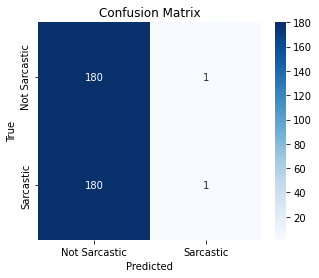

In [10]:
model_name = 'isarc_fan_16_glove'
model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### 1.1.2) Without GloVe

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       181
           1       0.00      0.00      0.00       181

    accuracy                           0.50       362
   macro avg       0.25      0.50      0.33       362
weighted avg       0.25      0.50      0.33       362



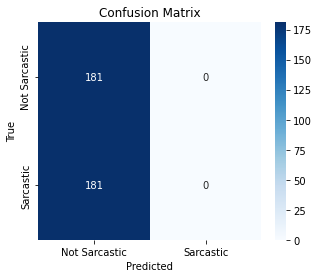

In [11]:
model_name = 'isarc_fan_16'
model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

#### 1.2) Sarcasm Corpus V2

In [12]:
folder_path = "Sarcasm_Corpus_V2"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 1.2.1) With GloVe

              precision    recall  f1-score   support

           0       0.54      0.31      0.40       181
           1       0.52      0.73      0.61       181

    accuracy                           0.52       362
   macro avg       0.53      0.52      0.50       362
weighted avg       0.53      0.52      0.50       362



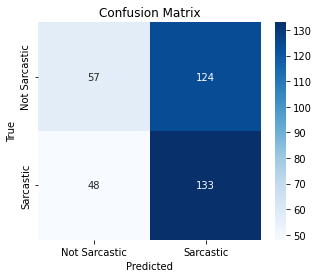

In [13]:
model_name = 'scv2_fan_16_glove'
model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### 1.2.2) Without GloVe

              precision    recall  f1-score   support

           0       0.48      0.24      0.32       181
           1       0.49      0.74      0.59       181

    accuracy                           0.49       362
   macro avg       0.49      0.49      0.45       362
weighted avg       0.49      0.49      0.45       362



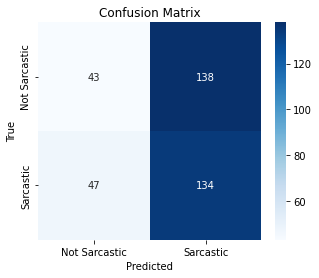

In [14]:
model_name = 'scv2_fan_16'
model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

#### 1.3) Combined Dataset

In [15]:
folder_path = "combined"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 1.3.1) With GloVe

              precision    recall  f1-score   support

           0       0.51      0.65      0.57       181
           1       0.52      0.38      0.44       181

    accuracy                           0.51       362
   macro avg       0.51      0.51      0.51       362
weighted avg       0.51      0.51      0.51       362



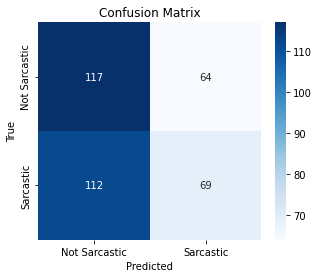

In [16]:
model_name = 'comb_fan_16_glove'
model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### 1.3.2) Without GloVe

              precision    recall  f1-score   support

           0       0.50      0.60      0.55       181
           1       0.50      0.41      0.45       181

    accuracy                           0.50       362
   macro avg       0.50      0.50      0.50       362
weighted avg       0.50      0.50      0.50       362



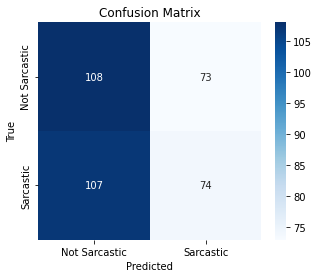

In [17]:
model_name = 'comb_fan_16'
model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

### 2) Bi-RNN with Hierarchical Attention Networks (HAN)

In [18]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
def load_data(folder_path):
    train_df = pd.read_csv(os.path.join(folder_path, 'train.csv'))
    val_df = pd.read_csv(os.path.join(folder_path, 'val.csv'))
    test_df = pd.read_csv(os.path.join(folder_path, 'test.csv'))
    return train_df, val_df, test_df

def build_vocab(dataframes, vocab_size=20000):
    word_freq = defaultdict(int)
    for df in dataframes:
        for text in df['text'].astype(str):
            for word in word_tokenize(text.lower()):
                word_freq[word] += 1
    sorted_words = sorted(word_freq.items(), key=lambda x: -x[1])[:vocab_size]
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(sorted_words, 2):
        word2idx[word] = i
    return word2idx

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)  # PAD

    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in word2idx:
                vector = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

class SarcasmDataset(Dataset):
    def __init__(self, dataframe, word2idx, max_sent_len=20, max_sents=15):
        self.docs = []
        self.labels = dataframe['sarcastic'].tolist()
        for text in dataframe['text'].astype('str'):
            sentences = sent_tokenize(text)
            tokenized_sentences = []
            for sent in sentences[:max_sents]:
                words = word_tokenize(sent)[:max_sent_len]
                word_ids = [word2idx.get(w.lower(), word2idx["<UNK>"]) for w in words]
                tokenized_sentences.append(word_ids)
            self.docs.append(tokenized_sentences)

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, idx):
        return self.docs[idx], self.labels[idx]

def collate_fn(batch):
    docs, labels = zip(*batch)
    max_sents = max(len(doc) for doc in docs)
    max_words = max(len(sent) for doc in docs for sent in doc)
    padded_docs = []
    for doc in docs:
        padded_sents = [sent + [0] * (max_words - len(sent)) for sent in doc]
        padded_sents += [[0] * max_words] * (max_sents - len(doc))
        padded_docs.append(padded_sents)
    return torch.LongTensor(padded_docs), torch.LongTensor(labels)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.context = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.attn(x))
        score = self.context(u).squeeze(-1)
        weights = F.softmax(score, dim=1)
        output = (x * weights.unsqueeze(-1)).sum(dim=1)
        return output

class HAN(nn.Module):
    def __init__(self, embedding_matrix, word_hidden=50, sent_hidden=50, dropout_rate=0.3, use_glove=True):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        if use_glove == True:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else: self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.word_gru = nn.GRU(embed_dim, word_hidden, bidirectional=True, batch_first=True)
        self.word_attn = Attention(word_hidden * 2)
        self.word_dropout = nn.Dropout(dropout_rate)

        self.sent_gru = nn.GRU(word_hidden * 2, sent_hidden, bidirectional=True, batch_first=True)
        self.sent_attn = Attention(sent_hidden * 2)
        self.sent_dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(sent_hidden * 2, 1)

    def forward(self, x):
        B, S, W = x.size()
        x = x.view(B * S, W)
        embedded = self.embedding(x)

        word_out, _ = self.word_gru(embedded)
        word_out = self.word_dropout(word_out)
        word_vec = self.word_attn(word_out).view(B, S, -1)

        sent_out, _ = self.sent_gru(word_vec)
        sent_out = self.sent_dropout(sent_out)
        doc_vec = self.sent_attn(sent_out)

        return torch.sigmoid(self.fc(doc_vec)).squeeze(1)

def evaluate_model(model, test_loader, dir_path, model_name):
    os.makedirs(dir_path, exist_ok=True)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            preds = model(x)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(rf'{dir_path}/{model_name}_confusion_matrix.png')
    plt.show()

#### 2.1) iSarcasmEval

In [20]:
folder_path = "iSarcasmEval"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 2.1.1) With GloVe

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       181
           1       0.00      0.00      0.00       181

    accuracy                           0.50       362
   macro avg       0.25      0.50      0.33       362
weighted avg       0.25      0.50      0.33       362



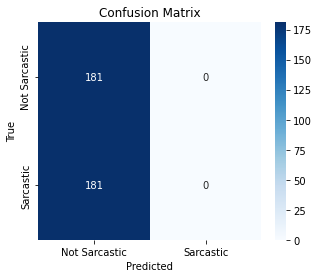

In [21]:
model_name = 'isarc_han_8_4_glove'
model = HAN(glove, word_hidden=8, sent_hidden=4)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### 2.1.2) Without GloVe

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       181
           1       0.00      0.00      0.00       181

    accuracy                           0.50       362
   macro avg       0.25      0.50      0.33       362
weighted avg       0.25      0.50      0.33       362



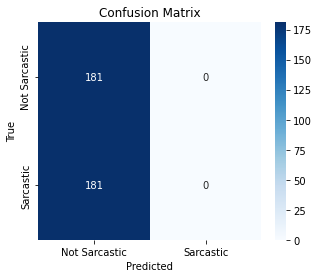

In [22]:
model_name = 'isarc_han_8_4'
model = HAN(glove, word_hidden=8, sent_hidden=4, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

#### 2.2) Sarcasm Corpus V2

In [23]:
folder_path = "Sarcasm_Corpus_V2"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 2.2.1) With GloVe

              precision    recall  f1-score   support

           0       0.51      0.25      0.33       181
           1       0.50      0.76      0.60       181

    accuracy                           0.50       362
   macro avg       0.50      0.50      0.47       362
weighted avg       0.50      0.50      0.47       362



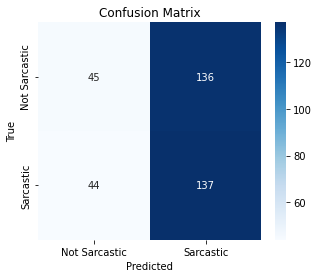

In [24]:
model_name = 'scv2_han_8_4_glove'
model = HAN(glove, word_hidden=8, sent_hidden=4)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### Without GloVe

              precision    recall  f1-score   support

           0       0.49      0.35      0.41       181
           1       0.50      0.64      0.56       181

    accuracy                           0.49       362
   macro avg       0.49      0.49      0.48       362
weighted avg       0.49      0.49      0.48       362



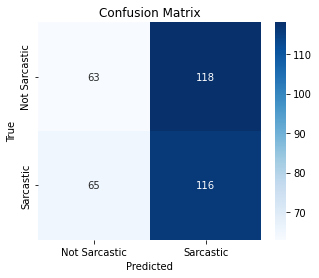

In [25]:
model_name = 'scv2_han_8_4'
model = HAN(glove, word_hidden=8, sent_hidden=4, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

#### 2.3) Combined Dataset

In [26]:
folder_path = "combined"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

test_data = SarcasmDataset(bb_test_df, word2idx)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

##### 2.3.1) With GloVe

              precision    recall  f1-score   support

           0       0.50      0.69      0.58       181
           1       0.50      0.31      0.39       181

    accuracy                           0.50       362
   macro avg       0.50      0.50      0.48       362
weighted avg       0.50      0.50      0.48       362



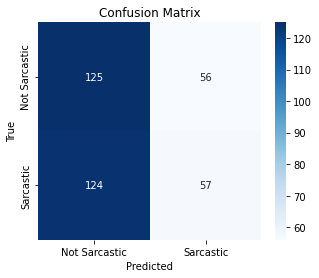

In [27]:
model_name = 'comb_han_8_4_glove'
model = HAN(glove, word_hidden=8, sent_hidden=4)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)

##### 2.3.2) Without GloVe

              precision    recall  f1-score   support

           0       0.51      0.69      0.59       181
           1       0.52      0.34      0.41       181

    accuracy                           0.51       362
   macro avg       0.52      0.51      0.50       362
weighted avg       0.52      0.51      0.50       362



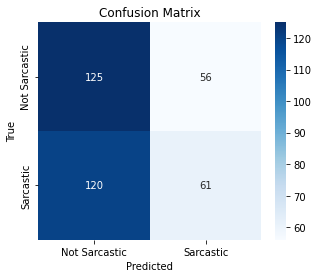

In [28]:
model_name = 'comb_han_8_4'
model = HAN(glove, word_hidden=8, sent_hidden=4, use_glove=False)
model.load_state_dict(torch.load(f"{model_name}/model.pth", weights_only=True))

bb_dir_path = rf'BIG-Bench-SNARKS/results'
evaluate_model(model, test_loader, bb_dir_path, model_name)